In [7]:
import matplotlib.pyplot as plt
import read_measurements
import pandas as pd
import numpy as np
import pyvista as pv
import lmfit
from scipy.signal import convolve2d
from scipy.fft import fft2
from scipy.fft import fftshift
from scipy.fft import ifft2
import diffractio


plt.style.use('dark_background')



# Filtrage de la phase

Dimensions: 201, 201


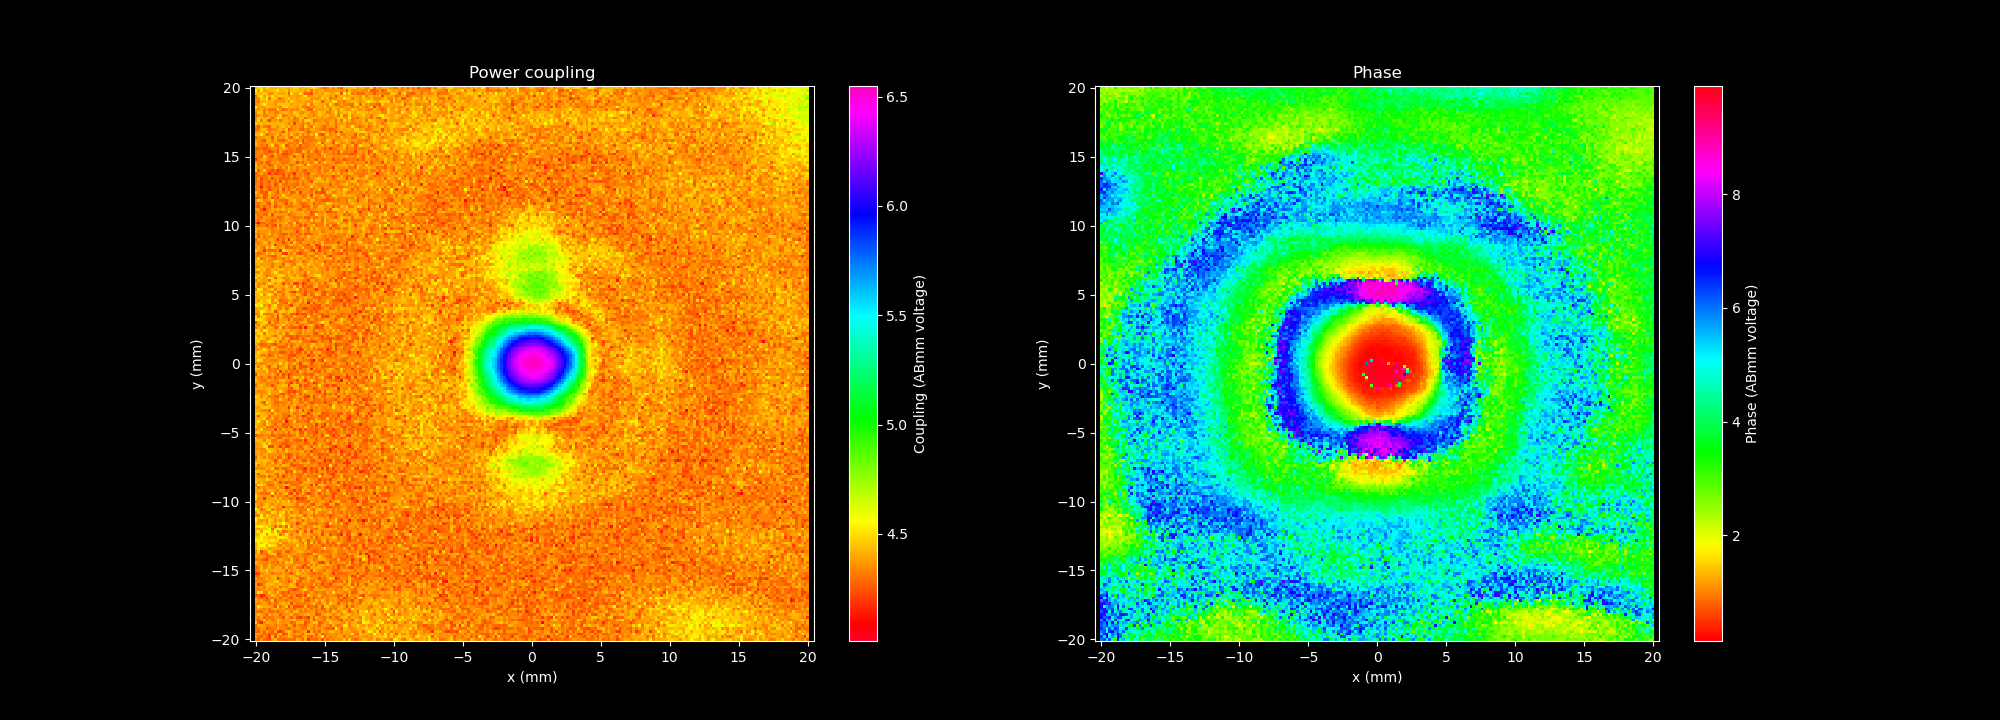

In [8]:
df = pd.read_csv("exemples_mesures/Thick_Lens_f_50mm_Transmitter_Big_Corrugated_Receiver_Small_Pyramidal_x0_83mm46_y0_237mm45_z0_300mm_dx_0mm2_dy_0mm2_nbx_201_nby_201_tintegr_0s3.txt", 
                 index_col=0, 
                 sep='\t')
data = read_measurements.Rectangular_sweep_data(df)

print(f"Dimensions: {data.Nx}, {data.Ny}")

data.plot()

On récupère les données:

In [9]:
# On récupère le meshgrid:
X, Y = data.X*1e3, data.Y*1e3 # On passe en mm

# On récupère les données de couplage en 2D et on converti en échelle linéaire.
couplage = 10**(data.ndarray_ch1-2) * 1e-5
phase = (data.ndarray_ch2 * 36 - 180) * np.pi / 180 

Regardons ce à quoi ressemble la phase:

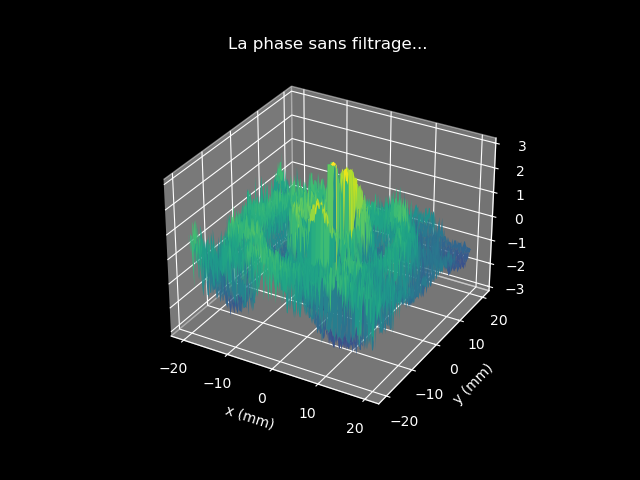

In [12]:
%matplotlib widget

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, phase, cmap='viridis')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_title('La phase sans filtrage...');
plt.show()

Elle est bien trop bruitée, on va effectuer un filtrage en supprimant les hautes fréquences de la fft.

In [13]:
def circular_mask(N, n):
    S = np.zeros((N,N))
    n0 = N//2
    for i in range(N):
        for j in range(N):
            S[i,j] = (i-n0)**2+(j-n0)**2 > n**2
    return S


In [14]:
cos_phi = np.cos(phase) #On filtre le cosinus afin de replier la phase

fft = fft2(cos_phi) * circular_mask(201,130)

phi_filtre = np.arccos(ifft2(fft))


c:\Users\Tanguy\anaconda3\envs\lerma\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


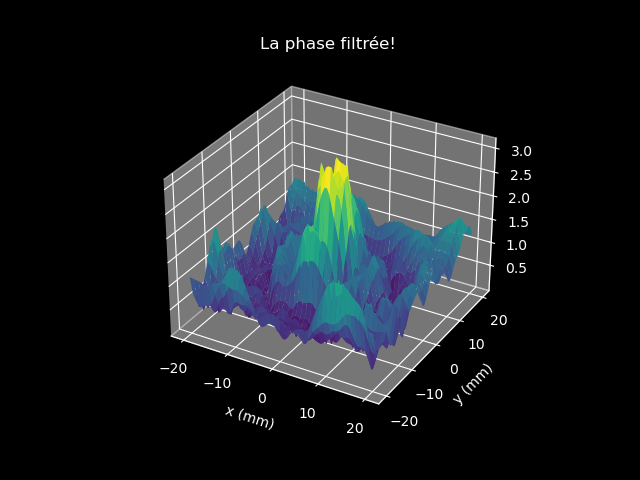

In [16]:
%matplotlib widget

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, phi_filtre, cmap='viridis')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_title('La phase filtrée!');
plt.show()

## Amplitude

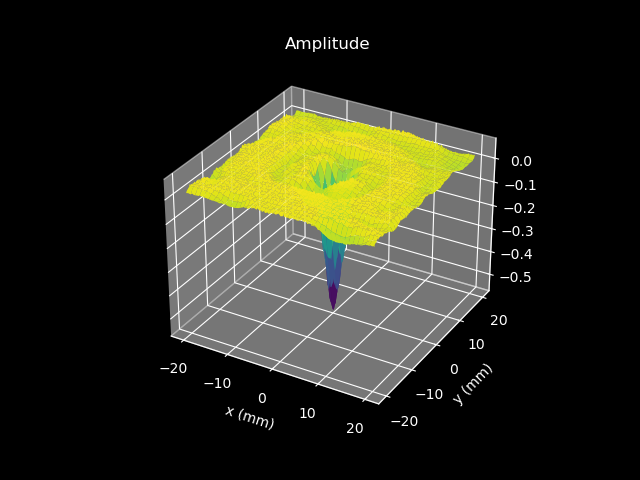

In [18]:

%matplotlib widget

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, np.sqrt(couplage)*np.cos(phi_filtre), cmap='viridis')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_title('Amplitude');
plt.show()

In [ ]:
def E0(x,y):
    OMEGA_0 = 1.3
    #Le champ u en z=0
    return (2/(np.pi*OMEGA_0**2))**0.5 * np.exp(-(x**2+y**2)/(OMEGA_0**2))

def deconv(a, b):
    """
    
    Returns function c such that b * c = a.
    
    https://en.wikipedia.org/wiki/Deconvolution
    
    """
    
    # Convert larger polynomial using fft

    ffta = fftshift(np.fft.fftn(a))
    ffta *= circular_mask(201,140)
    # Get it's shape so fftn will expand
    # smaller polynomial to fit.
    
    ashape = np.shape(a)
    
    # Convert smaller polynomial with fft
    # using the shape of the larger one

    fftb = fftshift(np.fft.fftn(b,ashape))
    
    # Divide the two in frequency domain

    fftquotient = ffta / fftb
    
    # Convert back to polynomial coefficients using ifft
    # Should give c but with some small extra components

    c = fftshift(np.fft.ifftn(fftquotient))
    
    # Get rid of imaginary part and round up to 6 decimals
    # to get rid of small real components

    #trimmedc = np.around(np.real(c),decimals=6)
    
    # Trim zeros and eliminate
    # empty rows of coefficients
    
    #cleanc = trim_zero_empty(trimmedc)            
    return np.array(c)



field = deconv(couplage, E0(X,Y))

#test = convolve2d(field, E0(X,Y), mode='same')

In [ ]:
couplage_x = couplage[:,100]
couplage_y = couplage[100,:]

plt.plot(data.x_, couplage_x)

In [ ]:
def model(x, delta_off, P0, x0, offset):
        return P0*(np.exp(-2*((x-x0)/delta_off)**2) + offset)

# On créer notre bibliothèque de paramètres
params = lmfit.Parameters()

# On lui ajoute les paramètres, avec une valeur initiale (value) et des bornes (min et max). 
# ATTENTION: les noms des variables doivent être les mêmes que ceux de la fonction.
params.add('delta_off', value=5*1e-3, min=0)
params.add('P0', value=0.35, min=0)
params.add('x0', value=0)
params.add('offset', value=0)

# On créé notre modèle
Model = lmfit.Model(model)

# On le fait fitter en indiquant le jeu de données "couplage" et la plage de variables "Y".
result = Model.fit(couplage_y, x=data.y_, params=params)

In [ ]:
result

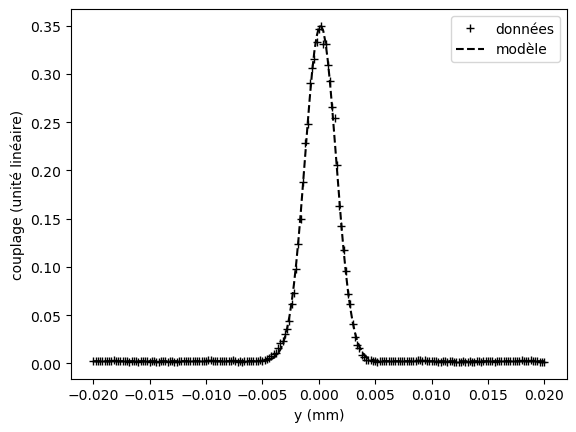

In [ ]:
%matplotlib inline

fit_model = model(data.y_, **result.params.valuesdict())

plt.plot(data.y_, couplage_y, 'k+', label='données')
plt.plot(data.y_, fit_model, 'k--', label='modèle')
plt.legend()
plt.xlabel('y (mm)')
plt.ylabel('couplage (unité linéaire)');